## Import packages

In [1]:
import gzip
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.stem.snowball import stopwords
from datetime import datetime
from wordcloud import WordCloud
import string
import tensorflow as tf
from implicit import bpr
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import defaultdict
sns.set()
sns.set_context('talk')

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        l = str(json.loads(l))
        yield eval(l)

## Import dataset

In [3]:
# data_modcloth = []
# for l in parse("modcloth_final_data.json.gz"):
#     data_modcloth.append(l)

In [4]:
# data_modcloth[0]

In [5]:
data_renttherunway = []
for l in parse("renttherunway_final_data.json.gz"):
    data_renttherunway.append(l)

In [6]:
data_renttherunway[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## Data Clean

In [7]:
df = pd.DataFrame(data_renttherunway)

In [8]:
def standardize_height(str_in):
    if type(str_in) == float:
        return str_in
    str_in = str_in.strip()
    if '\'' in str_in:
        str_in = str_in.replace('\'', '')
    if '"' in str_in:
        str_in = str_in.replace('"', '')

    foot,inch = str_in.strip().split(' ')
    output = int(foot) * 12 + int(inch)

    return output

In [9]:
def standardize_weight(str_in):
    if type(str_in) == float:
        return str_in
    if 'lbs' in str_in:
        str_in = str_in.replace('lbs', '')
    if(str_in.isnumeric()):
        return int(str_in)

    return str_in

In [10]:
df.shape

(192544, 15)

In [11]:
# drop entries with null values
df = df.dropna() 
df = df.reset_index(drop=True)

In [12]:
df.shape

(146381, 15)

In [13]:
rating_dict = {'2':1, '4':2, '6':3, '8':4, '10':5}

In [14]:
df['height'] = df['height'].apply(lambda x: standardize_height(x))
df['weight'] = df['weight'].apply(lambda x: standardize_weight(x))
df['age'] = df['age'].apply(lambda x: int(x))
df['fit_sml'] = df['fit'].apply(lambda x: 0 if x=='small' else 1 if x=='fit' else 2)
df['fit'] = df['fit'].apply(lambda x: x == 'fit')
df['review_date'] = df['review_date'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
df['rating'] = df['rating'].apply(lambda x: rating_dict[x] if type(x) == str else x)

In [15]:
punctuation = set(string.punctuation)
stopwordsSet = set(stopwords.words("english"))
def clean_text(text):
    text = ''.join([c for c in text.lower() if not c in punctuation])
    text = ' '.join(w for w in text.split() if w not in stopwordsSet)
    return text
df['review_text'] = df['review_text'].apply(lambda x: clean_text(x))

## Exploratory Data Analysis

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146381 entries, 0 to 146380
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             146381 non-null  bool          
 1   user_id         146381 non-null  object        
 2   bust size       146381 non-null  object        
 3   item_id         146381 non-null  object        
 4   weight          146381 non-null  int64         
 5   rating          146381 non-null  int64         
 6   rented for      146381 non-null  object        
 7   review_text     146381 non-null  object        
 8   body type       146381 non-null  object        
 9   review_summary  146381 non-null  object        
 10  category        146381 non-null  object        
 11  height          146381 non-null  int64         
 12  size            146381 non-null  int64         
 13  age             146381 non-null  int64         
 14  review_date     146381 non-null  dat

In [17]:
df.describe()

,weight,rating,height,size,age,fit_sml
count,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000
mean,137.209870,4.540992,65.263053,11.437919,34.089800,0.995928
std,21.540182,0.718926,2.659230,7.826784,8.113217,0.513818
min,50.000000,1.000000,54.000000,0.000000,0.000000,0.000000
25%,123.000000,4.000000,63.000000,4.000000,29.000000,1.000000
50%,135.000000,5.000000,65.000000,9.000000,32.000000,1.000000
75%,148.000000,5.000000,67.000000,16.000000,37.000000,1.000000
max,300.000000,5.000000,78.000000,58.000000,117.000000,2.000000


In [18]:
df.nunique()

fit                    2
user_id            77347
bust size            101
item_id             5736
weight               186
rating                 5
rented for             9
review_text       144375
body type              7
review_summary    119690
category              68
height                24
size                  56
age                   83
review_date         2240
fit_sml                3
dtype: int64

In [19]:
for i in df.columns:
    if df[i].nunique() >= 20:
        continue
    print(f"{i}'s value counts:")
    print(df[i].value_counts())


fit's value counts:
True     107733
False     38648
Name: fit, dtype: int64
rating's value counts:
5    94291
4    40761
3     8341
2     2205
1      783
Name: rating, dtype: int64
rented for's value counts:
wedding            42622
formal affair      30496
party              27198
everyday           13263
work               12124
other              11510
date                5929
vacation            3238
party: cocktail        1
Name: rented for, dtype: int64
body type's value counts:
hourglass            43982
athletic             37518
petite               19358
pear                 18051
straight & narrow    12866
full bust            10797
apple                 3809
Name: body type, dtype: int64
fit_sml's value counts:
1    107733
0     19622
2     19026
Name: fit_sml, dtype: int64


### Heights

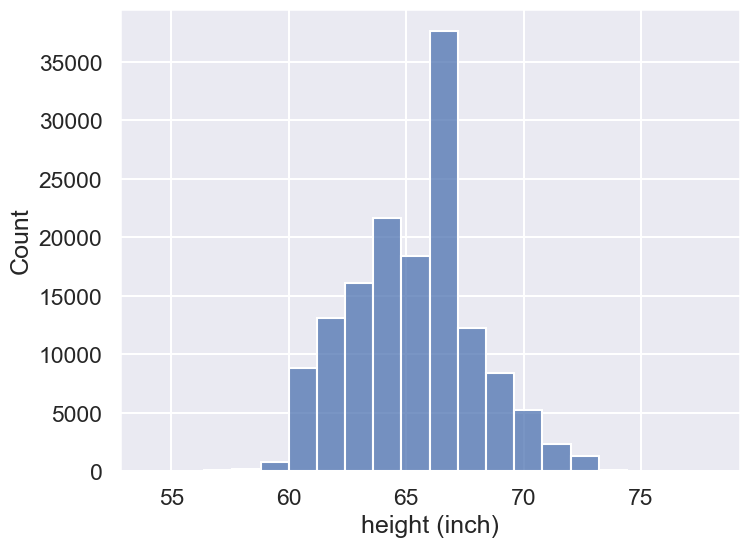

In [20]:
# overview of the whole distribution of height
plt.figure(figsize=(8, 6))
sns.histplot(data=df,x = 'height', bins=20)
plt.xlabel('height (inch)')
plt.show()

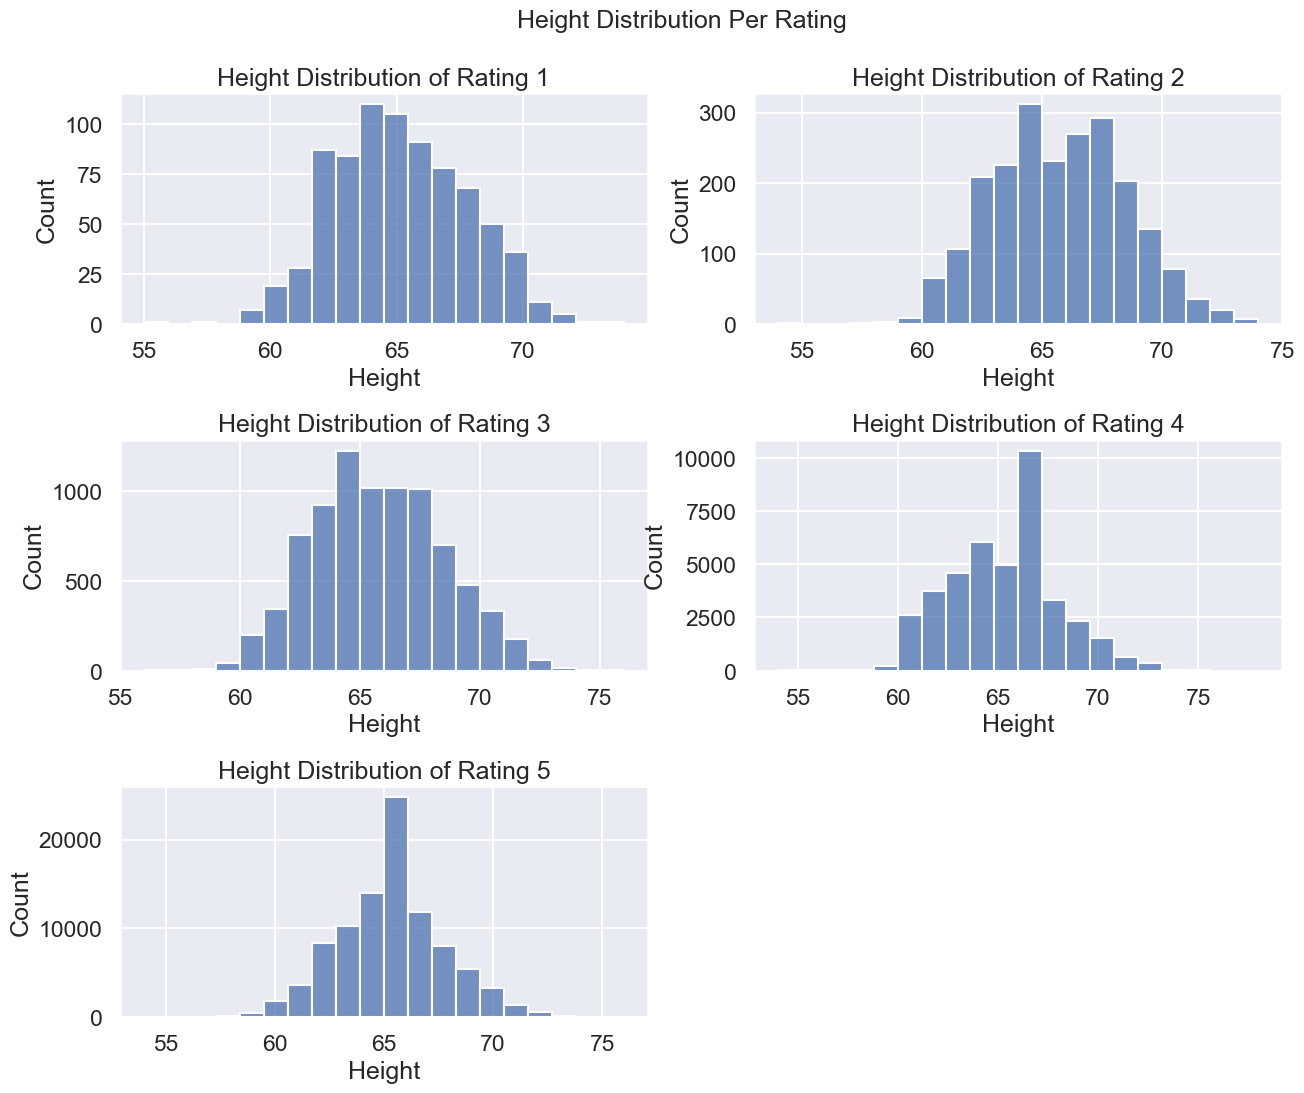

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axs = axs.flat
axs[-1].remove()
axs = axs[:-1]
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Height Distribution Per Rating", fontsize=18, y=0.95)

for ax, gb in zip(axs, df.groupby('rating')):
    rate, dfs = gb
    sns.histplot(data = dfs,x = 'height', bins=20, ax = ax)
    ax.set_title(f'Height Distribution of Rating {int(rate)}')
    ax.set_xlabel("Height")
plt.show()

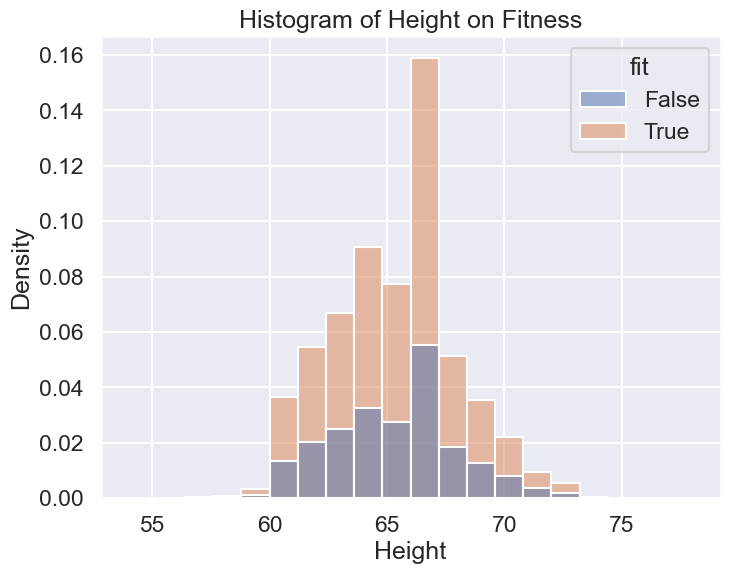

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="height", hue="fit", bins=20, stat="density").set(title='Histogram of Height on Fitness', xlabel = 'Height')
plt.show()

### Weights

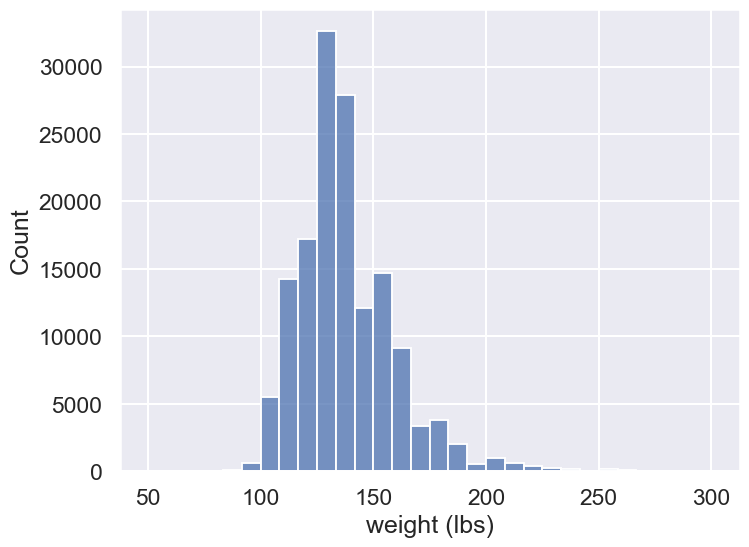

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x = 'weight', bins=30)
plt.xlabel('weight (lbs)')
plt.show()

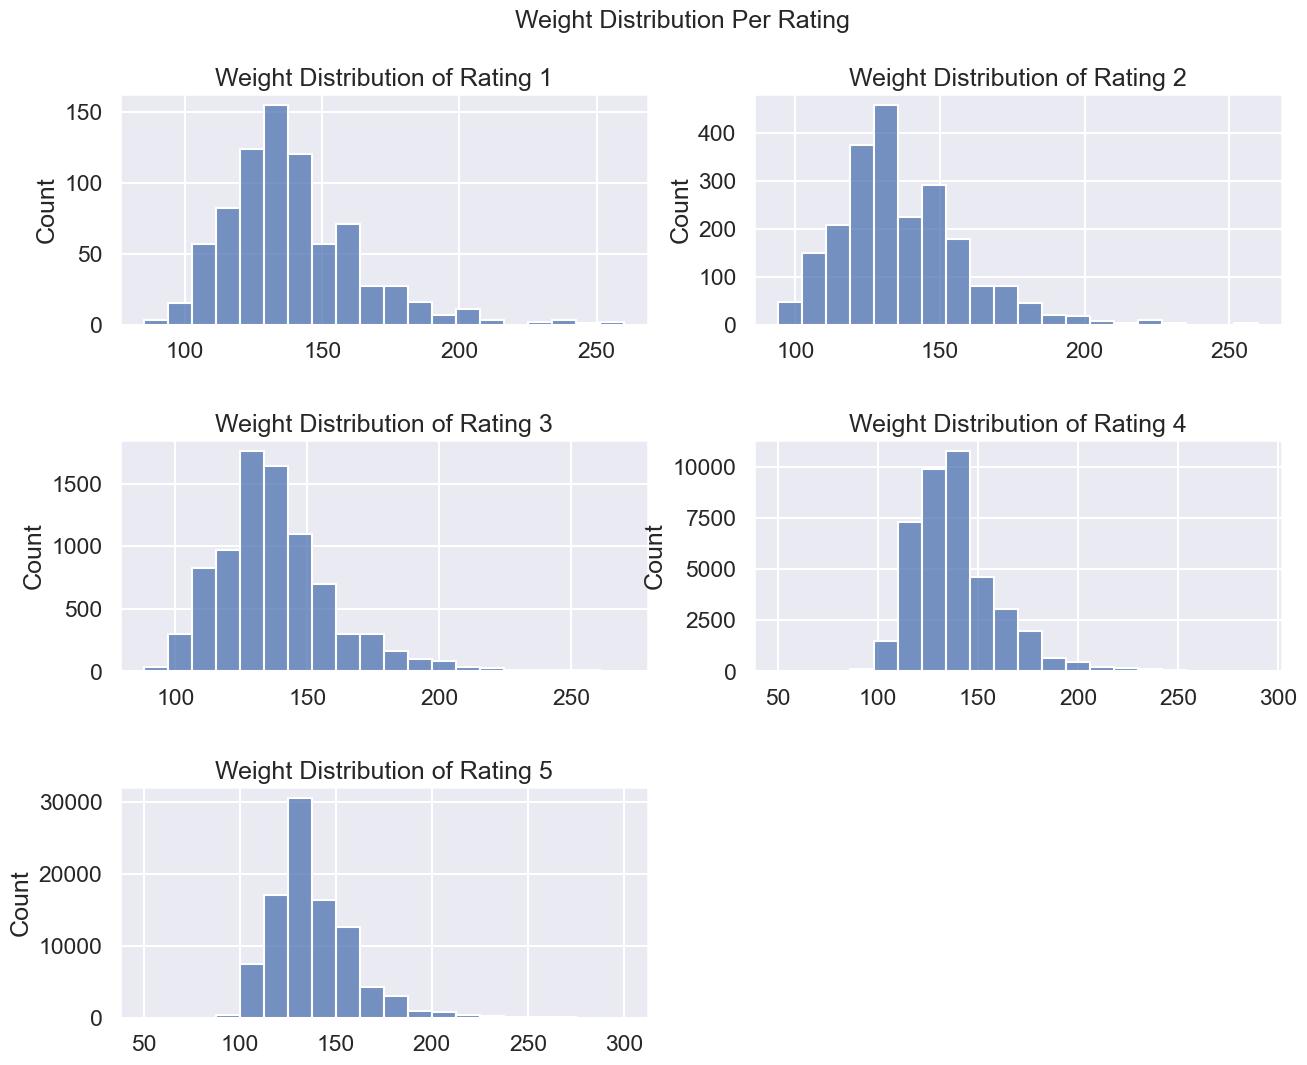

In [24]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axs = axs.flat
axs[-1].remove()
axs = axs[:-1]
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Weight Distribution Per Rating", fontsize=18, y=0.95)

# loop through tickers and axes
for gb, ax in zip(df.groupby('rating'), axs.ravel()):
    rate, dfs = gb
    sns.histplot(data = dfs,x = 'weight', bins=20, ax = ax)
    ax.set_title(f'Weight Distribution of Rating {int(rate)}')
    ax.set_xlabel("")

plt.show()

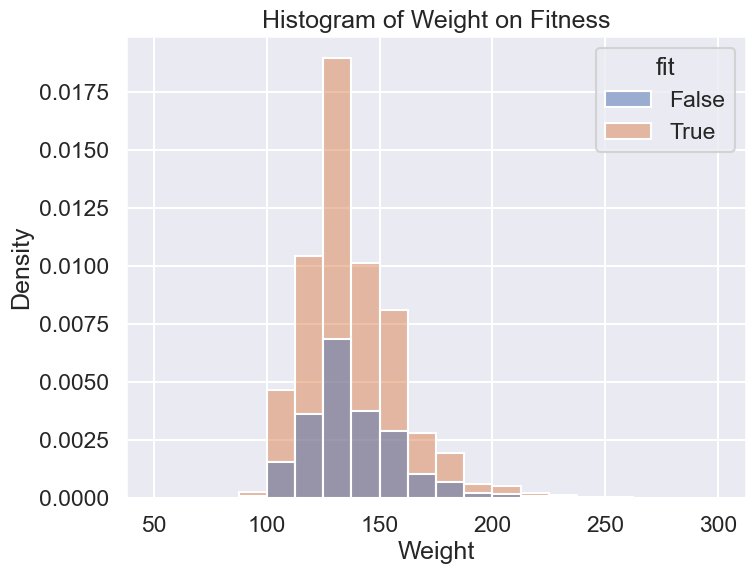

In [25]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="weight", hue="fit", bins=20, stat="density").set(title='Histogram of Weight on Fitness', xlabel = 'Weight')
plt.show()

### Category data and standardize date

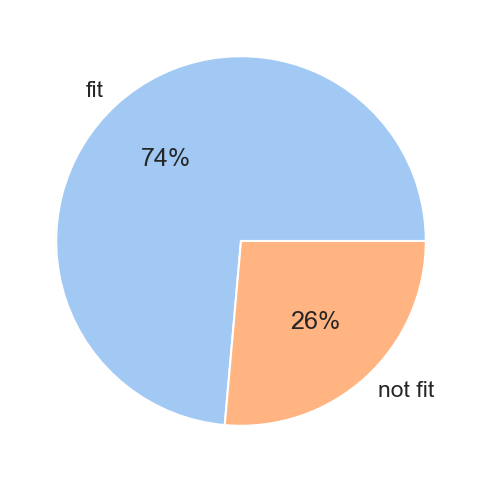

In [26]:
data = df['fit'].value_counts().tolist()
labels = ['fit', 'not fit']
colors = sns.color_palette('pastel')[0:2]
plt.figure(figsize=(8, 6))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

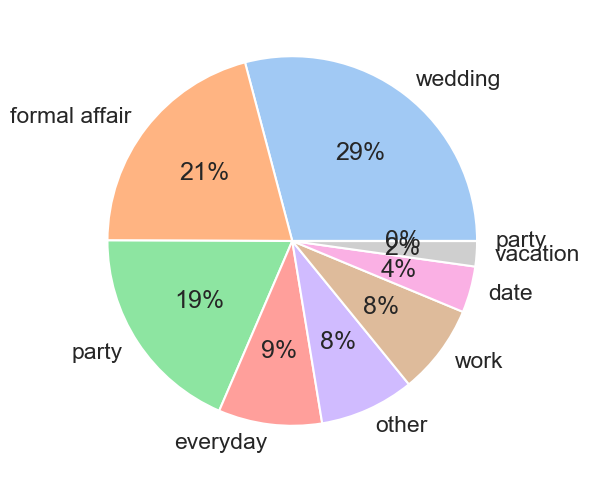

In [27]:
data = df['rented for'].value_counts().tolist()
labels = ['wedding', 'formal affair', 'party', 'everyday', 'other', 'work', 'date', 'vacation', 'party']
colors = sns.color_palette('pastel')[0:9]
plt.figure(figsize=(8, 6))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [28]:
df['body type'].value_counts()

hourglass            43982
athletic             37518
petite               19358
pear                 18051
straight & narrow    12866
full bust            10797
apple                 3809
Name: body type, dtype: int64

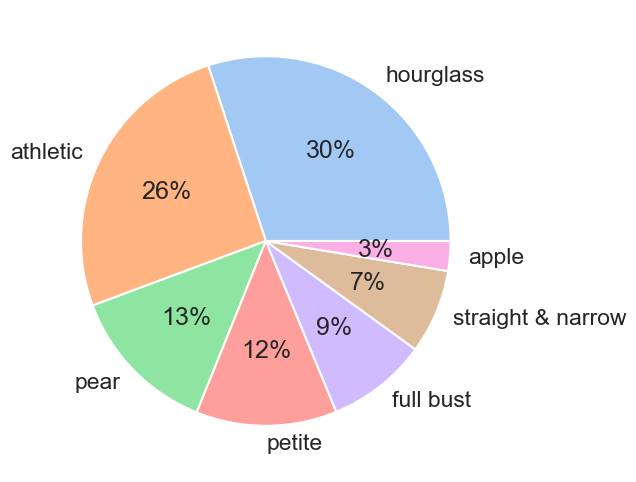

In [29]:
data = df['body type'].value_counts().tolist()
labels = ['hourglass', 'athletic', 'pear', 'petite', 'full bust', 'straight & narrow', 'apple']
colors = sns.color_palette('pastel')[0:7]
plt.figure(figsize=(8, 6))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

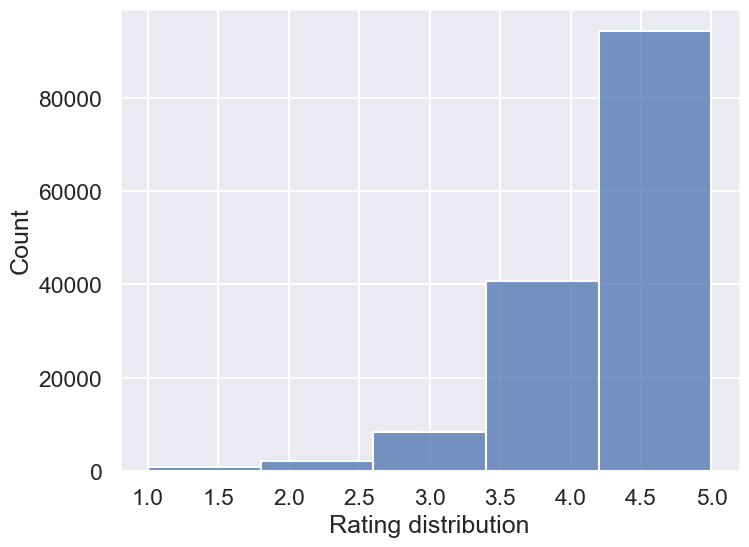

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x = 'rating', bins=5)
plt.xlabel('Rating distribution')
plt.show()

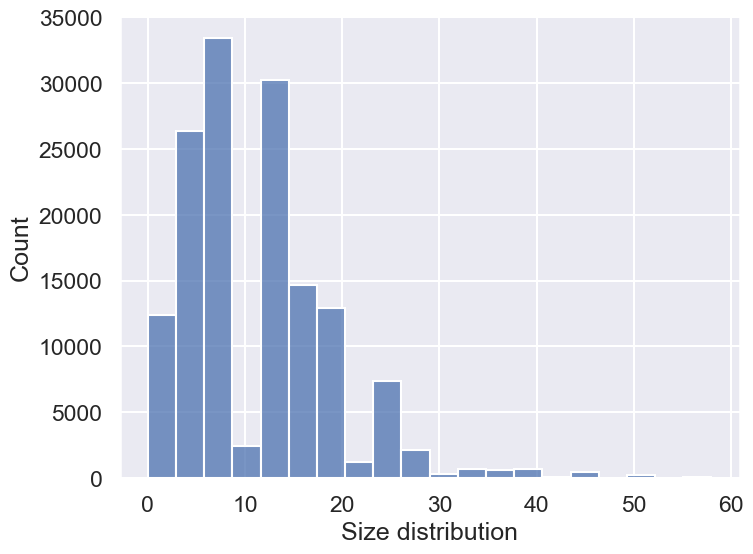

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x = 'size', bins=20)
plt.xlabel('Size distribution')
plt.show()

In [32]:
# drop users who are younger than 10 and older than 80
df = df[(df['age'] > 10) & (df['age'] < 80)]
df = df.reset_index(drop=True)

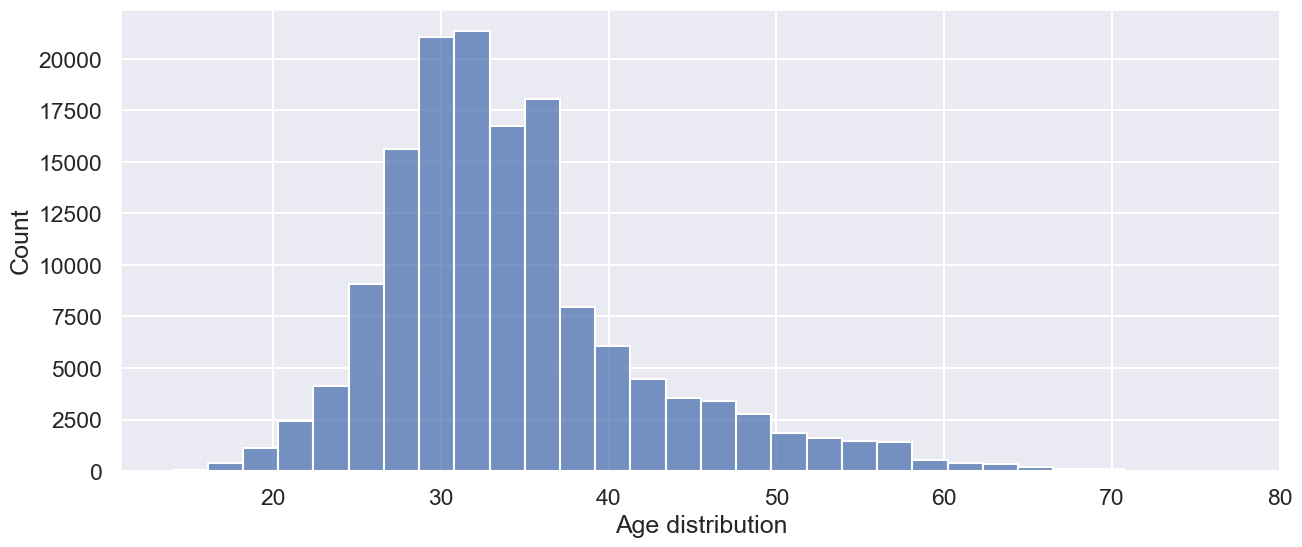

In [33]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x = 'age', bins=30)
plt.xlabel('Age distribution')
plt.show()

In [34]:
df_date = df["review_date"].apply(lambda x : pd.to_datetime(x))
min_date = min(df_date)
date_diff = (df_date - min_date).astype(str).apply(lambda x : x.split()[0]).astype(int)
std_date_diff = ((date_diff - np.mean(date_diff))/np.std(date_diff))
df['review_date'] = std_date_diff
df.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,fit_sml
0,True,420272,34d,2260466,137,5,vacation,adorable romper belt zipper little hard naviga...,hourglass,So many compliments!,romper,68,14,28,0.070136,1
1,True,273551,34b,153475,132,5,other,rented dress photo shoot theme hollywood glam ...,straight & narrow,I felt so glamourous!!!,gown,66,12,36,-2.034953,1
2,True,909926,34c,126335,135,4,formal affair,rented companys black tie awards banquet liked...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34,-1.549788,1
3,True,151944,34b,616682,145,5,wedding,always petite upper body extremely athletic im...,athletic,Was in love with this dress !!!,gown,69,12,27,0.392903,1
4,True,734848,32b,364092,138,4,date,didnt actually wear fit perfectly fabric littl...,athletic,Traditional with a touch a sass,dress,68,8,45,0.090436,1


In [35]:
df['bust size'].unique()

array(['34d', '34b', '34c', '32b', '34d+', '36a', '36d', '32d+', '32c',
       '30dd', '36b', '36c', '32d', '34a', '34dd', '32a', '34ddd/e',
       '38d+', '38a', '38b', '38d', '36ddd/e', '38dd', '38f', '42dd',
       '40dd', '32dd', '38c', '30ddd/e', '32ddd/e', '36dd', '36d+', '40d',
       '28dd', '42c', '30d', '30b', '34aa', '32aa', '36f', '28c', '36aa',
       '34g', '42ddd/e', '40c', '34f', '28g', '28aa', '36g', '28f',
       '44ddd/e', '42d', '40ddd/e', '30c', '30aa', '44dd', '32i', '32g',
       '30g', '30h', '30a', '34j', '38ddd/e', '32h', '28a', '32f', '44d',
       '40h', '38g', '40g', '28b', '34h', '36j', '36h', '28ddd/e', '44f',
       '34i', '30f', '36i', '30i', '28h', '42b', '42j', '40f', '38aa',
       '38i', '48dd', '28d', '46ddd/e', '42g', '48d', '38h', '40b', '40j',
       '32j', '38j', '44b', '44c', '44g', '42f', '44h'], dtype=object)

In [36]:
# Drop bust size
df.drop(columns=['bust size'])

,fit,user_id,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,fit_sml
0,True,420272,2260466,137,5,vacation,adorable romper belt zipper little hard naviga...,hourglass,So many compliments!,romper,68,14,28,0.070136,1
1,True,273551,153475,132,5,other,rented dress photo shoot theme hollywood glam ...,straight & narrow,I felt so glamourous!!!,gown,66,12,36,-2.034953,1
2,True,909926,126335,135,4,formal affair,rented companys black tie awards banquet liked...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34,-1.549788,1
3,True,151944,616682,145,5,wedding,always petite upper body extremely athletic im...,athletic,Was in love with this dress !!!,gown,69,12,27,0.392903,1
4,True,734848,364092,138,4,date,didnt actually wear fit perfectly fabric littl...,athletic,Traditional with a touch a sass,dress,68,8,45,0.090436,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146265,True,66386,2252812,140,5,work,fit like glove,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,69,8,42,0.126976,1
146266,True,118398,682043,100,5,work,pattern contrast dress really stunning usually...,petite,LOVE it!,dress,61,4,29,0.401023,1
146267,True,47002,683251,135,3,everyday,like dvf wraps fit fantastic albeit collar dro...,straight & narrow,"Loud patterning, flattering fit",dress,68,8,31,-0.025273,1
146268,True,961120,126335,165,5,wedding,dress perfection looked incredible photos love...,pear,loved this dress it was comfortable and photog...,dress,66,16,31,-0.228271,1


### Clothes Category

In [37]:
most_common_cat = df['category'].value_counts()[:9].index.tolist()
cnt_cat = []
for i in most_common_cat:
    cnt_cat.append(len(df[df['category'] == i]))
most_common_cat.append('other')
cnt_cat.append(len(df) - sum(cnt_cat))

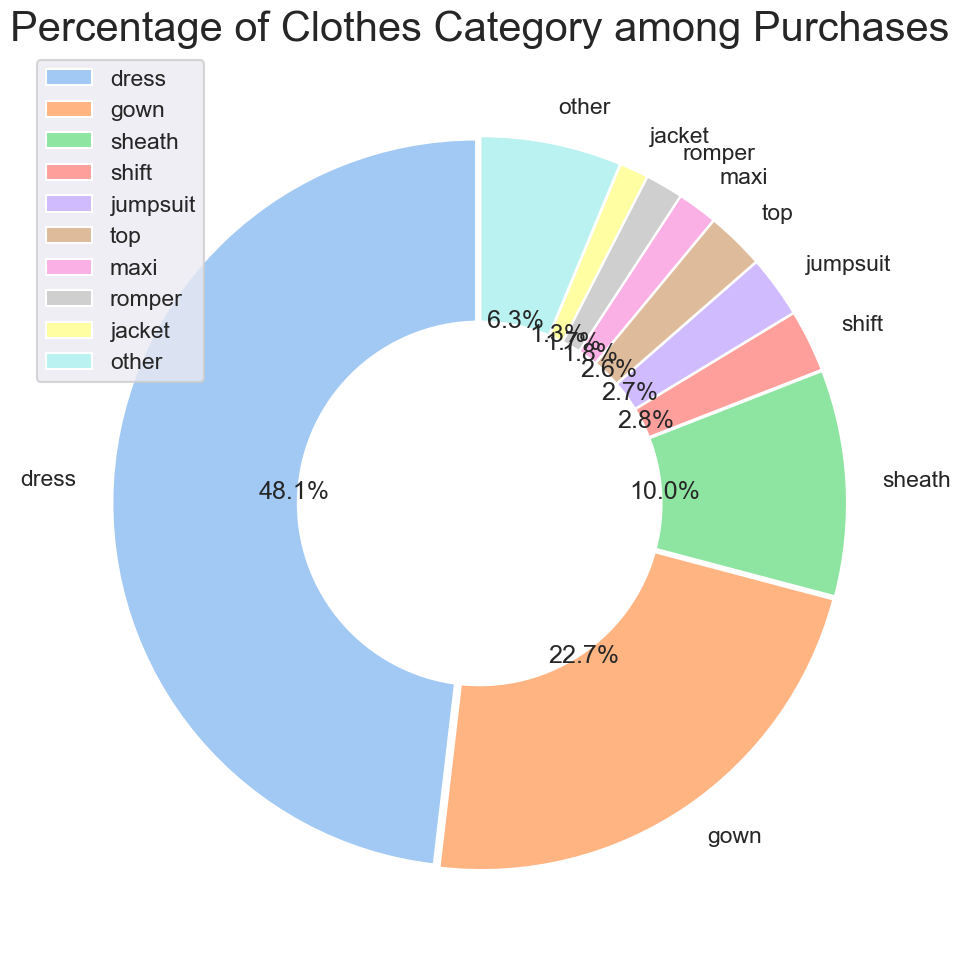

In [38]:
fig = plt.figure(figsize=(10, 20))
colors = sns.color_palette('pastel')[0:10]
explode = [0.01] * len(most_common_cat)
plt.pie(cnt_cat, labels = most_common_cat, colors=colors,autopct='%1.1f%%',startangle=90, pctdistance=0.5, explode = explode)
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()
plt.legend()
plt.title("Percentage of Clothes Category among Purchases",fontsize=30)
plt.show()

### Review

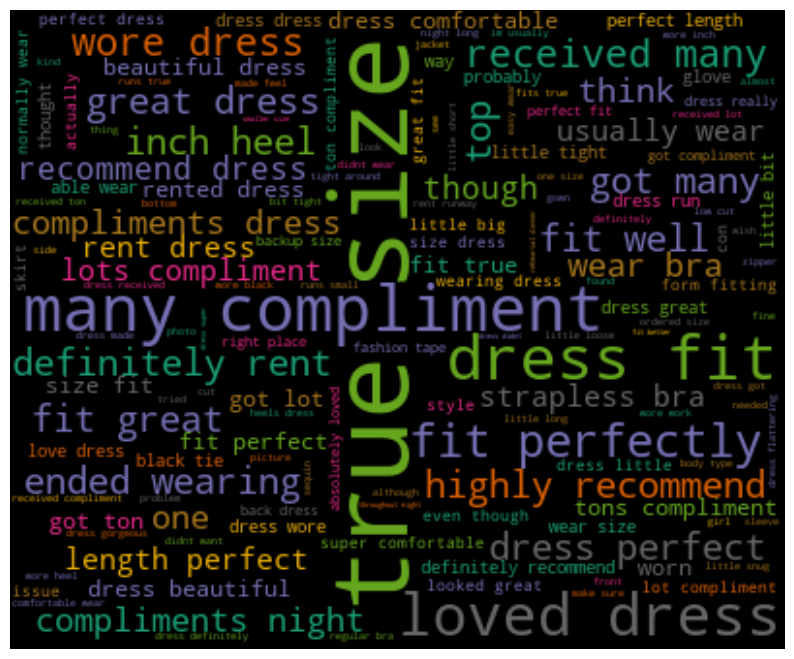

In [39]:
# review among all dataset
text = " ".join(d for d in df['review_text'])
wordcloud = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(text)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

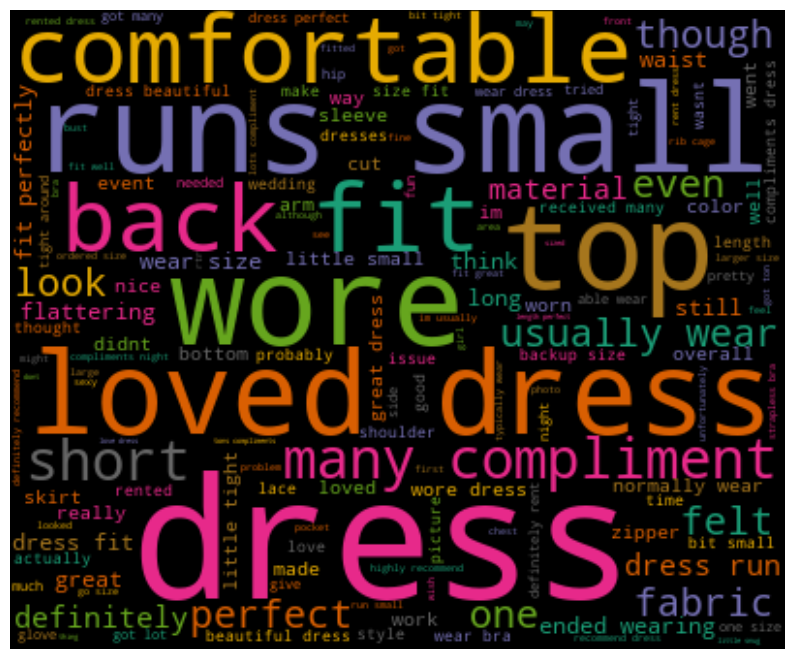

In [40]:
# review for people who think the clothes fit small
text_small = " ".join(d for d in df[df['fit_sml'] == 0]['review_text'])
wordcloud = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(text_small)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

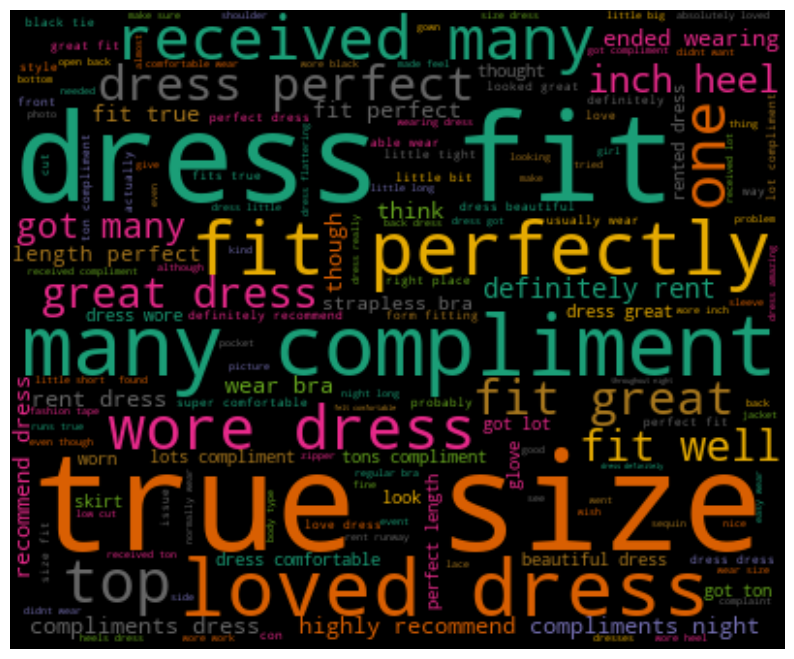

In [41]:
# review for people who think the clothes fit well
text_fit = " ".join(d for d in df[df['fit_sml'] == 1]['review_text'])
wordcloud = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(text_fit)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

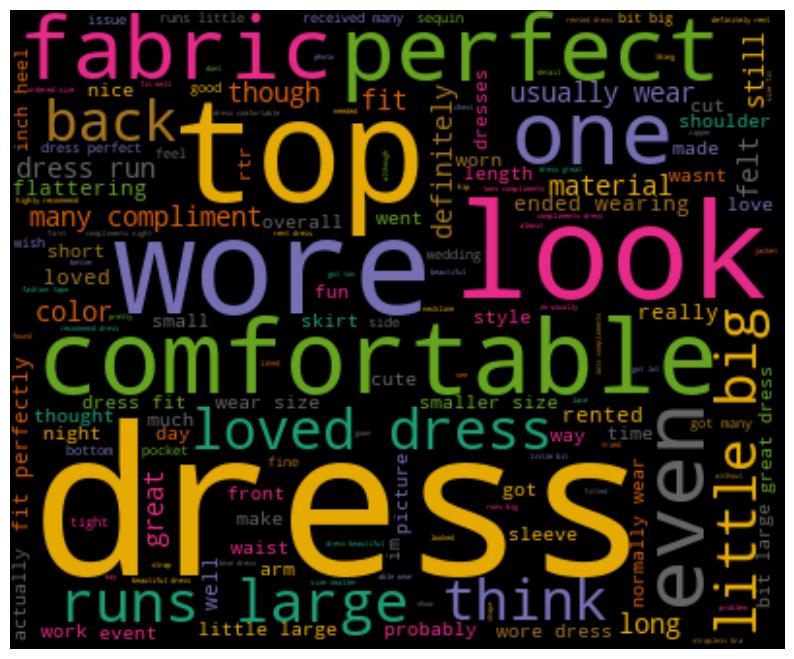

In [42]:
# review for people who think the clothes fit large
text_large = " ".join(d for d in df[df['fit_sml'] == 2]['review_text'])
wordcloud = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(text_large)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
len(df)

146270

In [44]:
#Convert the data frame back to list of dict
data_renttherunway = df.to_dict('records')

In [45]:
len(data_renttherunway)

146270

# Process `review_text` in `data_renttherunway`

In [46]:
from nltk.stem.snowball import stopwords
stopwordsSet = set(stopwords.words("english"))

In [47]:
len(stopwordsSet)

179

In [48]:
punctuation = set(string.punctuation)

In [49]:
def clean_text(text):
  text = ''.join([c for c in text.lower() if not c in punctuation])
  text = ' '.join(w for w in text.split() if w not in stopwordsSet)
  return text

In [50]:
# Process the review_text for each entry
for d in data_renttherunway:
  d['review_text'] = clean_text(d['review_text'])

In [51]:
data_renttherunway[0]

{'fit': True,
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': 137,
 'rating': 5,
 'rented for': 'vacation',
 'review_text': 'adorable romper belt zipper little hard navigate full day wearbathroom use thats expected wish pockets absolutely perfect got million compliments',
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': 68,
 'size': 14,
 'age': 28,
 'review_date': 0.07013649419996568,
 'fit_sml': 1}

In [52]:
data_renttherunway_train = data_renttherunway[:len(data_renttherunway)//2]
data_renttherunway_valid = data_renttherunway[len(data_renttherunway)//2:]

In [53]:
print(len(data_renttherunway_valid))
print(len(data_renttherunway_train))

73135
73135


### Baseline model

In [54]:
#Baseline model, simply return the mean rating of each user 

In [55]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
ratingDict = {}

In [56]:
for d in data_renttherunway_train:
    user,item = d['user_id'], d['item_id']
    usersPerItem[d['item_id']].add(d['user_id'])
    itemsPerUser[d['user_id']].add(d['item_id'])
    reviewsPerUser[d['user_id']].append(d)
    reviewsPerItem[d['item_id']].append(d)
    ratingDict[(user,item)] = d['rating']  

In [57]:
globalMean = 0
for d in data_renttherunway_train:
    globalMean+=int(d['rating'])
globalMean = globalMean/len(data_renttherunway_train)

In [58]:
globalMean

4.54331031653791

In [59]:
ypred = []
for d in data_renttherunway_valid:
    reviews_this_user = reviewsPerUser[d['user_id']]
    userMean = 0
    userLen = len(reviews_this_user)
    if userLen == 0:
        ypred.append(globalMean)
    else:
        for r in reviews_this_user:
            userMean+=r['rating']
        ypred.append(userMean/userLen)


In [60]:
ytest = []
for d in data_renttherunway_valid:
    ytest.append(int(d['rating']))

In [61]:
mean_squared_error(ytest, ypred)

0.6241660980034783

### LinearRegression model

In [62]:
#Improved model, use linear regression to predict rating

In [78]:
df.head(3)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,fit_sml
0,True,420272,34d,2260466,137,5,vacation,adorable romper belt zipper little hard naviga...,hourglass,So many compliments!,romper,68,14,28,0.070136,1
1,True,273551,34b,153475,132,5,other,rented dress photo shoot theme hollywood glam ...,straight & narrow,I felt so glamourous!!!,gown,66,12,36,-2.034953,1
2,True,909926,34c,126335,135,4,formal affair,rented companys black tie awards banquet liked...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34,-1.549788,1


In [101]:
feat_h = df['height'].to_numpy()
feat_w = df['weight'].to_numpy()
feat_a = df['age'].to_numpy()
feat_s = df['size'].to_numpy()
feat_f = df['fit'].to_numpy()
bias = [1] * len(df)
X = []
X = np.column_stack((feat_h, feat_w, feat_a, feat_s, feat_f, bias))
y = df['rating'].to_numpy()

In [102]:
X

array([[ 68, 137,  28,  14,   1,   1],
       [ 66, 132,  36,  12,   1,   1],
       [ 65, 135,  34,   8,   1,   1],
       ...,
       [ 68, 135,  31,   8,   1,   1],
       [ 66, 165,  31,  16,   1,   1],
       [ 66, 155,  30,  16,   1,   1]], dtype=int64)

In [103]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)

In [104]:
clf = LinearRegression(fit_intercept=False)
clf.fit(Xtrain, ytrain)

LinearRegression(fit_intercept=False)

In [105]:
ypred = clf.predict(Xtest)
# accuracy_score(ypred, ytest)

In [106]:
mean_squared_error(ytest, ypred)

0.47595528421301414

### Latent factor model (Tensorflow)

In [69]:
userIDs = {}
itemIDs = {}
interactions = []

for d in data_renttherunway:
    u = d['user_id']
    i = d['item_id']
    r = int(d['rating'])
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((u,i,r))

In [70]:
interactionsTrain = interactions[:len(interactions)//2]
interactionsValid = interactions[len(interactions)//2:]

In [71]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i,r in interactionsTrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

In [72]:
mu = sum([r for _,_,r in interactionsTrain]) / len(interactionsTrain)

In [73]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [74]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu)
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2) +\
                            tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

In [75]:
modelLFM = LatentFactorModel(mu, 5, 0.00001)

In [76]:
def trainingStep(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [77]:
for i in range(100):
    obj = trainingStep(modelLFM, interactionsTrain)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.16641225
iteration 20, objective = 0.13658369
iteration 30, objective = 0.13189934
iteration 40, objective = 0.1270522


KeyboardInterrupt: 

In [ ]:
interactionsValid[0]

In [ ]:
ypred = []
ytest = []
for d in interactionsValid:
    ytest.append(d[2])

for d in interactionsValid:
    u = d[0]
    i = d[1]
    r = d[2]
    ypred.append(modelLFM.predict(userIDs[u], itemIDs[i]).numpy())
    

In [ ]:
mean_squared_error(ytest, ypred)

### Jaccord model

In [108]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
ratingDict = {} # To retrieve a rating for a specific user/item pair

for d in data_renttherunway_train:
    user,item = d['user_id'], d['item_id']
    usersPerItem[d['item_id']].add(d['user_id'])
    itemsPerUser[d['user_id']].add(d['item_id'])
    reviewsPerUser[d['user_id']].append(d)
    reviewsPerItem[d['item_id']].append(d)
    ratingDict[(user,item)] = d['rating']

In [109]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [111]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [112]:
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['item_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return sum([d['rating'] for d in data_renttherunway_train]) / len(data_renttherunway_train)

In [113]:
simPredictions = [predictRating(d['user_id'], d['item_id']) for d 
                  in data_renttherunway_valid]

In [114]:
labels = [d['rating'] for d in data_renttherunway_valid]

In [115]:
mean_squared_error(labels, simPredictions)

0.5489802878228296